## Visualizing Gaussian Process Realizations from Model Selection

Jeffrey S. Hazboun

In [1]:
%load_ext autoreload
%autoreload 2

The purpose of thise notebook is to look at the output from the noise analysis and try to understand various aspects of what the model selection and data are telling us. 

First we import the usual suspects

In [2]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import numpy as np
import scipy.stats as sps
import json, pickle
import enterprise.signals.utils as utils

You'll need sksparse for get_coefficients() with common signals!


Then we import various parts of the `la_forge` package, which specifically deals with output of `PTMCMCSampler`, `Enterprise` and `enterprise_extensions`. You can 
```
pip install la-forge
```
or install the latest version from GitHub via:
```
pip install git+https://github.com/Hazboun6/la_forge@master --upgrade
```
Please feel free to suggest any changes to the code base for this package!

In [3]:
import la_forge.diagnostics as dg
import la_forge.core as co
from la_forge.rednoise import plot_rednoise_spectrum, plot_free_spec
from la_forge.utils import epoch_ave_resid

## Monitor Your Chains
The beauty of having this in a separate notebook is that even if your analysis is runnning somewhere else you can look at the chains here. It is important to look at various parts of the output to understand if the sampling seems to be going pretty well.
 
Next you'll want to point to the chains for the pulsar you wish to investigate.

In [4]:
psrname = 'J1600-3053'#
chaindir = '/Users/hazboun/nanograv_detection/ent_ext_testing/{0}/chrom_dmgp/'.format(psrname)

Next use a speciality opbject to load upo chains from a HyperModel analysis. The code automatically looks for a dictionary containing the parameters in each model at `'./model_params.json'`, but you can also provide one with a keyword argument. The burn is automatically set to 25% of the chain length, however sometimes it's also useful to look at the first samples. You set the burn with `cH.set_burn(0)`

In [5]:
cH=co.HyperModelCore(label='PSR {}, DM Model Selection',
                     chaindir=chaindir)

Appending PTMCMCSampler sampling parameters to end of parameter list.
If unwanted please provide a parameter list.
No burn specified. Burn set to 25% of chain length, 850
You may change the burn length with core.set_burn()
Red noise frequencies must be set before plotting most red noise figures.
Please use core.set_rn_freqs() to set, if needed.


/Users/hazboun/anaconda3/envs/pint/lib/python3.6/site-packages/la_forge/core.py:109: UserWarning: loadtxt: Empty input file: "/Users/hazboun/nanograv_detection/ent_ext_testing/J1600-3053/chrom_dmgp/draw_from_dm_gp_prior_jump.txt"
  self.jumps[ky] = np.loadtxt(path, dtype=dtype)
/Users/hazboun/anaconda3/envs/pint/lib/python3.6/site-packages/la_forge/core.py:109: UserWarning: loadtxt: Empty input file: "/Users/hazboun/nanograv_detection/ent_ext_testing/J1600-3053/chrom_dmgp/draw_from_red_prior_jump.txt"
  self.jumps[ky] = np.loadtxt(path, dtype=dtype)
/Users/hazboun/anaconda3/envs/pint/lib/python3.6/site-packages/la_forge/core.py:109: UserWarning: loadtxt: Empty input file: "/Users/hazboun/nanograv_detection/ent_ext_testing/J1600-3053/chrom_dmgp/draw_from_empirical_distr_jump.txt"
  self.jumps[ky] = np.loadtxt(path, dtype=dtype)
/Users/hazboun/anaconda3/envs/pint/lib/python3.6/site-packages/la_forge/core.py:109: UserWarning: loadtxt: Empty input file: "/Users/hazboun/nanograv_detection/e

The `HyperModelCore` has quite a few atrributes that are useful for lloking at the chains. The `get_param` method takes a string and returns the samples for that parameter. Here we are using it to find out which model is the most favored.

In [6]:
vals,bins=np.histogram(cH.get_param('nmodel'),bins=[-0.5,0.5,1.5,2.5,3.5])
np.argmax(vals)

2

### Noise Flower Plots
One of the hallmark figures we look at for the model selection anlayses is a radial histogram that plots the time spent in each of the possible models. We call these "noise flowers". 

Running the analysis notebook leads to a set of labels being saved for the models being analyzed in a given chain directory under `'model_labels.json'`. This is a list of labels that should help us keep track of the various models being analyzed. If these are not descriptive enough, feel free to edit the nested list. 

In [8]:
with open(chaindir+'/model_labels.json' , 'r') as fin:
    model_labels= json.load(fin)

model_labels

[['A', 'sq_exp_rfband', False, None],
 ['B', 'periodic_rfband', False, None],
 ['C', 'sq_exp_rfband', True, 'sq_exp'],
 ['D', 'sq_exp_rfband', True, 'periodic']]

There is a `noise_flower` function in `la_forge.diagnostics` that takes as input a `HyperModelCore` and various options in order to fill out the table with useful information about the models being analyzed. 

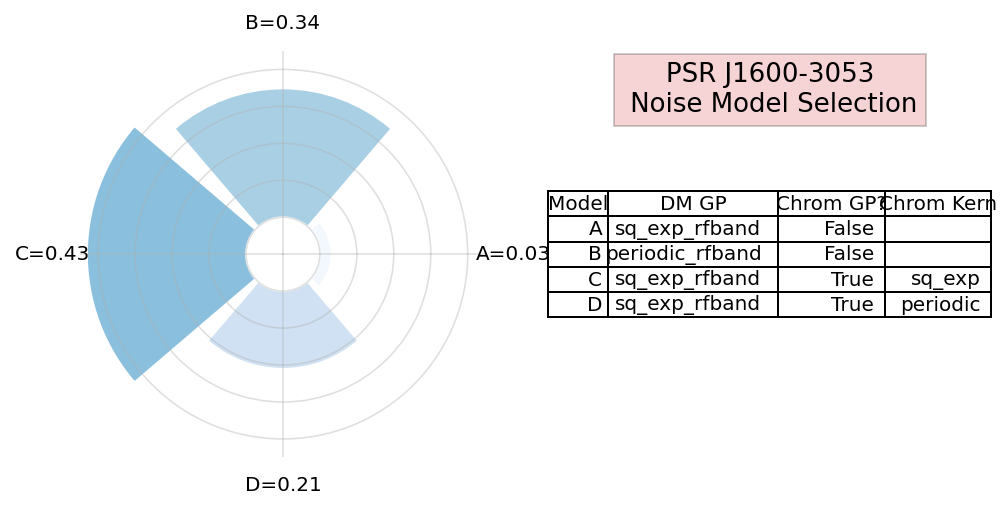

In [10]:
dg.noise_flower(cH, 
                colLabels=['Model', 'DM GP','Chrom GP?', 'Chrom Kern'],
                #
                cellText=model_labels,
                colWidths=[0.14,0.4,0.25,0.25])

### Single model `core`s
A `core.HyperModelCore` object has a method to return __only__ the samples from a particular model. It is nice to look at how various parameters, say for achromatic RN or `ECORR`, change from model to model.

When a given pulsar analysis gets stuck in one of the `nmodel` parameters it's also useful to see what the posteriors look like in that model. 

The individual cores are pulled out using the `model_core` method and an integer tha gives which model you'd like returned.

In [11]:
c0=cH.model_core(0)
c1=cH.model_core(1)
c2=cH.model_core(2)
c3=cH.model_core(3)

# Gaussian Process Realizations

Most of the advanced noise models that we are unleashing on ur various pulsars are various iterations of Gaussian processes. These are meant to model stochastic processes in data and while there are often functions that are used to describe them, they are inherently realization dependent. In order to get a feeling for how well the GPs are fitting the data we use `enterprise` to make realizations of the GPs. Thankfully this is straightofrward using the the various tools available. 

We start by importing a few functions, retrieving the pulsar and making the PTA object. 

In [13]:
from enterprise_extensions.models import model_singlepsr_noise

In [14]:
from la_forge.gp import Signal_Reconstruction as gp

No sksparse library. Using scipy instead!


In [31]:
psrname='J1600-3053'#
filepath = '/Users/hazboun/nanograv_detection/12p5yr/noise_model_selection/no_dmx_pickles/'#'./no_dmx_pickles/'
filepath += '{0}_ng12p5yr_v3_nodmx_ePSR.pkl'.format(psrname)

In [32]:
with open(filepath,'rb') as fin:
    psr=pickle.load(fin)

with open(chaindir+'/model_kwargs.json' , 'r') as fin:
    model_kwargs=json.load(fin)

You shouldn't need this next cell, but there are some of the original model_kwarg dictionaries with spurious entries that need to be deleted. If you get an error when calling `model_singlepsr_noise` and it matches one of the these kwargs, try running this cell to delete them.

In [33]:
pta= model_singlepsr_noise(psr, **model_kwargs['2'])

The `Signal_Reconstruction` class take an `enterprise.pulsar.Pulsar` object, an `enterprise.signal_base.PTA` object and a `la_forge.core.Core` object as inputs. (One can alternatively use a chain array and burn value for the latter.) 

In [34]:
sr=gp(psr,pta,core=c2)

The `gp_types` atribute will tell you which Gaussian process signals are available in this `PTA`. Additionally there are a number of other options one can use for the `gp_type` flag that goes into a signal reconstruction. These include `['achromatic_rn','DM','FD','all']`. Also any of the timing parameter perturbations can also be called. 

In [36]:
sr.gp_types

['linear_timing_model', 'red_noise', 'dm_gp', 'chrom_gp']

Every pulsar has a list of the timing parameters that are fit with the linearized timing model. These are also modeled as Gaussian process and can be retrieved with the same functions.

In [37]:
psr.fitpars 

['Offset',
 'ELONG',
 'ELAT',
 'F0',
 'F1',
 'DM',
 'DM1',
 'DM2',
 'PMELONG',
 'PMELAT',
 'PX',
 'SINI',
 'PB',
 'T0',
 'A1',
 'OM',
 'ECC',
 'XDOT',
 'M2',
 'FD1',
 'FD2',
 'JUMP1']

In [22]:
# parameter indices to pull from chain. Change `size` flag for more or less.
# first one picks the "most likely values"
idxs = np.argsort(c2.get_param('lnpost',to_burn=False))[::-1][:50]

# this one just picks random values. Should be broadly the same as above if well converged
# idxs = np.random.randint(sr.burn, sr.chain.shape[0],size=100)

### The `reconstruct_signal` method
There are few useful options for regaining GPs using this method. Here is the docstring:

```
Parameters
----------
gp_type : str, {'achrom_rn','gw','DM','none','all',timing parameters}
    Type of gaussian process signal to be reconstructed. In addition
    any GP in `psr.fitpars` or `Signal_Reconstruction.gp_types` may be
    called.
    ['achrom_rn','red_noise'] : Return the achromatic red noise.
    ['DM'] : Return the timing-model parts of dispersion model.
    [timing parameters] : Any of the timing parameters from the linear
        timing model. A list is available as `psr.fitpars`.
    ['timing'] : Return the entire timing model.
    ['gw'] : Gravitational wave signal. Works with common process in
        full PTAs.
    ['none'] : Returns no Gaussian processes. Meant to be used for
        returning deterministic signal.
    ['all'] : Returns all Gaussian processes.

det_signal : bool
    Whether to include the deterministic signals in the reconstruction.

mlv : bool
    Whether to use the maximum likelihood value for the reconstruction.

idx : int, optional
    Index of the chain array to use.
```

In particular you can choose which GP signals to return. To return a single gp choose from the list `sr.gp_types`. If you want the dispersion measure elements of the DM model you can use `'DM'`. This returns either the DMX GP or the DM1 and DM2 GPs. 

To get all of the deterministic signals, but no GP use `reconstruct_signal(gp_type='none',det_signal=True, ...)`.

The next cell gives the timing model components of the dispersion model + any deterministic models (DM, CW, ...). The only determinsitic model this pulsar has is the solar wind, but if you add DM dips or something this is the flag to use. You get all of them at the same time. One can construct these signals separately but it would take different code.

In [38]:
DM = np.array([sr.reconstruct_signal(gp_type='DM',det_signal=True, idx=idx)[psrname]
               for idx in idxs])

The next two cells return realizations of the DM GP and the Chromatic GP. 

In [39]:
dm_gp = np.array([sr.reconstruct_signal(gp_type='dm_gp', idx=idx)[psrname]
                  for idx in idxs])

In [40]:
chrom_gp = np.array([sr.reconstruct_signal(gp_type='chrom_gp', idx=idx)[psrname]
                    for idx in idxs])

In [41]:
mn_DM = np.mean(DM,axis=0)
mn_dmgp = np.mean(dm_gp,axis=0)
mn_chrom_gp = np.mean(chrom_gp,axis=0)

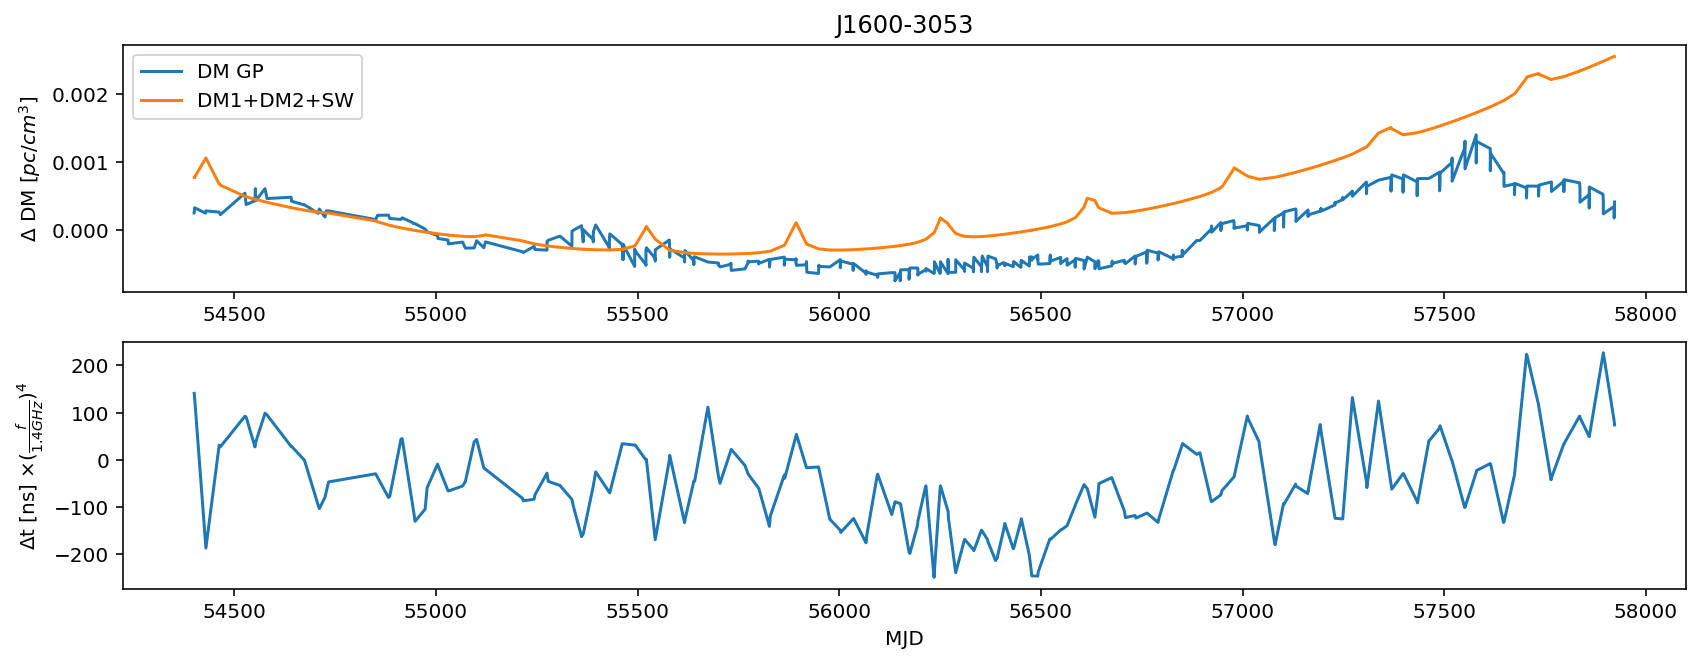

In [47]:
fig = plt.figure(figsize=[14,5])

fig.add_subplot(211)
plt.plot(psr.toas/(24*3600),(mn_dmgp*psr.freqs**2*2.41e-4),label='DM GP')
plt.plot(psr.toas/(24*3600),(mn_DM*psr.freqs**2*2.41e-4),label='DM1+DM2+SW')
# plt.plot(psr.toas/(24*3600),(mlv_sgp*psr.freqs**4*2.41e-10),label='Scatt')
# plt.plot(psr.toas/(24*3600),((mlv_dmgp+mlvDM)*psr.freqs**2*2.41e-4),label='DMGP+DM1+DM2+SW')
# plt.ylim(-10,10)
plt.legend()#loc='lower left')

plt.ylabel(r'$\Delta$ DM [$pc/cm^3$]')
plt.title(psrname)

fig.add_subplot(212)
plt.plot(psr.toas/(24*3600),mn_chrom_gp*(psr.freqs/1400)**4*1e9,label='Chrom GP')
plt.ylabel(r'$\Delta$t [ns] $\times (\frac{f}{1.4 GHz})^4$')
plt.xlabel('MJD')
plt.show()

## Plot DMX
Use the DMX values from the data release as a comparison of how well the DM GP models are matching the changes in the dispersion measure.

In [48]:
#Load DMX values
dtypes = {'names': ('DMXEP', 'DMX_value', 'DMX_var_err', 
                    'DMXR1', 'DMXR2', 'DMXF1', 
                    'DMXF2', 'DMX_bin'),
          'formats': ('f4','f4','f4','f4','f4','f4','f4','U6')}
dmx = np.loadtxt('./dmx/{0}_NANOGrav_12yv3.dmx'.format(psrname),
                 skiprows=4,
                 dtype=dtypes)

In [49]:
# Convert signals into units of DM [pc/cm^3]
dm_units = (dm_gp + DM)*psr.freqs[np.newaxis,:]**2*2.41e-4 
dm_mean = (mn_DM + mn_dmgp)*psr.freqs**2*2.41e-4

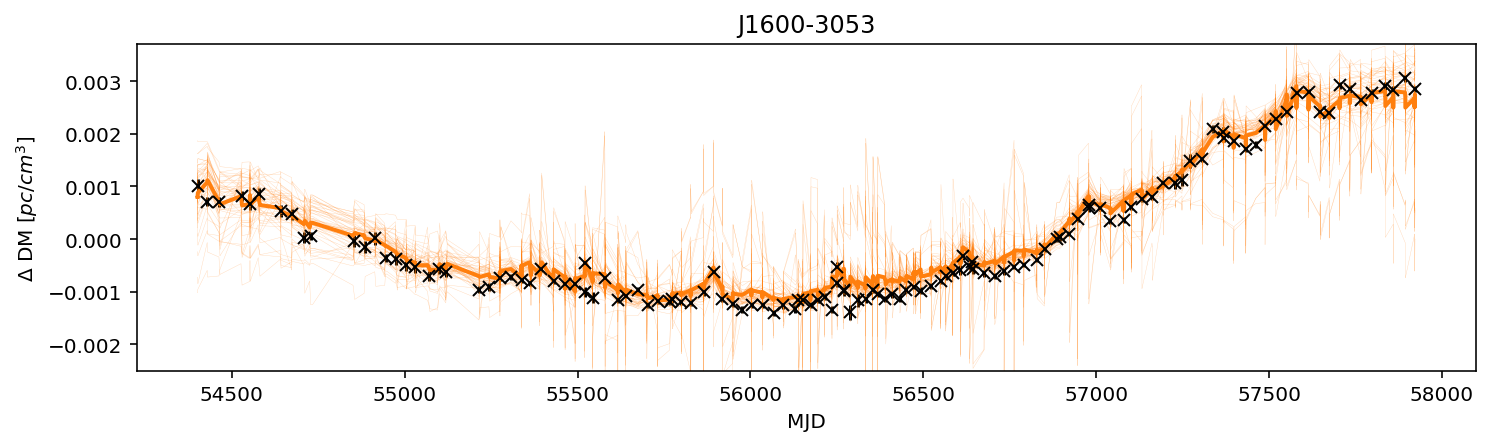

In [51]:
plt.figure(figsize=[12,3])
for dm in dm_units:
    plt.plot(psr.toas/(24*3600),dm-dm.mean(),linewidth=0.2,alpha=0.3,color='C1')

plt.plot(psr.toas/(24*3600),dm_mean-dm_mean.mean(),linewidth=2,color='C1')
plt.errorbar(x=dmx['DMXEP'],
             y=dmx['DMX_value']-dmx['DMX_value'].mean(),
             yerr=dmx['DMX_var_err'],
             marker='x',color='k',linestyle='none')

plt.ylim(-0.0025,0.0037) # J1600
#plt.ylim(-0.0015,0.0023) # J1911
plt.xlabel('MJD')
plt.ylabel(r'$\Delta$ DM [$pc/cm^3$]')
plt.title(psrname)
plt.show()

In [52]:
# Here we extract only the SW but this would be all of the deterministic signals if there were more.
sw = np.array([sr.reconstruct_signal(gp_type='none',det_signal=True, idx=idx)[psrname]for idx in idxs])
mn_sw = np.mean(sw, axis=0)

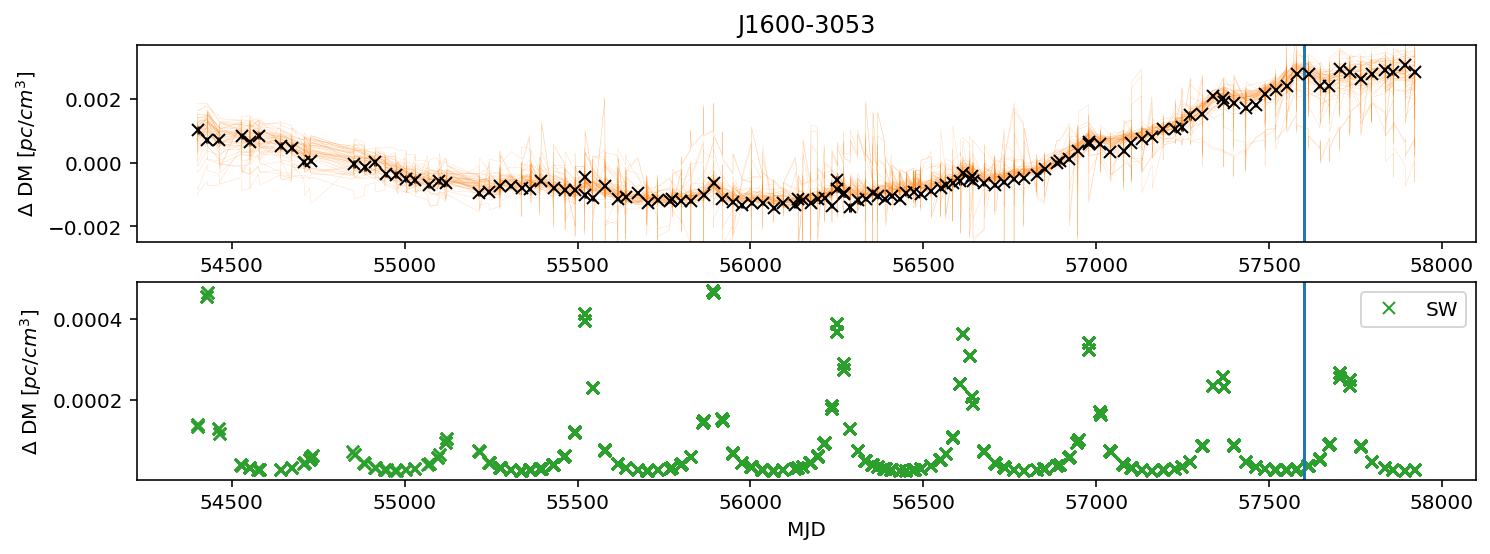

In [57]:
fig = plt.figure(figsize=[12,4])

fig.add_subplot(211)
for dm in dm_units:
    plt.plot(psr.toas/(24*3600),dm-dm.mean(),linewidth=0.2,alpha=0.3,color='C1')

plt.title(psrname)

plt.errorbar(x=dmx['DMXEP'],
             y=dmx['DMX_value']-dmx['DMX_value'].mean(),
             yerr=dmx['DMX_var_err'],
             marker='x',color='k',linestyle='none')
plt.axvline(57600)
plt.ylim(-0.0025,0.0037) # J1600

plt.ylabel(r'$\Delta$ DM [$pc/cm^3$]')

fig.add_subplot(212)
plt.plot(psr.toas/(24*3600),mn_sw*psr.freqs**2*2.41e-4 ,'x',linewidth=2,color='C2',label='SW')
plt.ylabel(r'$\Delta$ DM [$pc/cm^3$]')
plt.xlabel('MJD')
plt.axvline(57600)
plt.legend(loc='upper right')

plt.show()

#### NOTE: The cusp in DMX that is not aligned with a solar wind cusp.

## Looking at Residuals

Uncorrected residuals will look really bad since we have stripped all of the DMX parameters and DM1/DM2 are set to zero initially. 

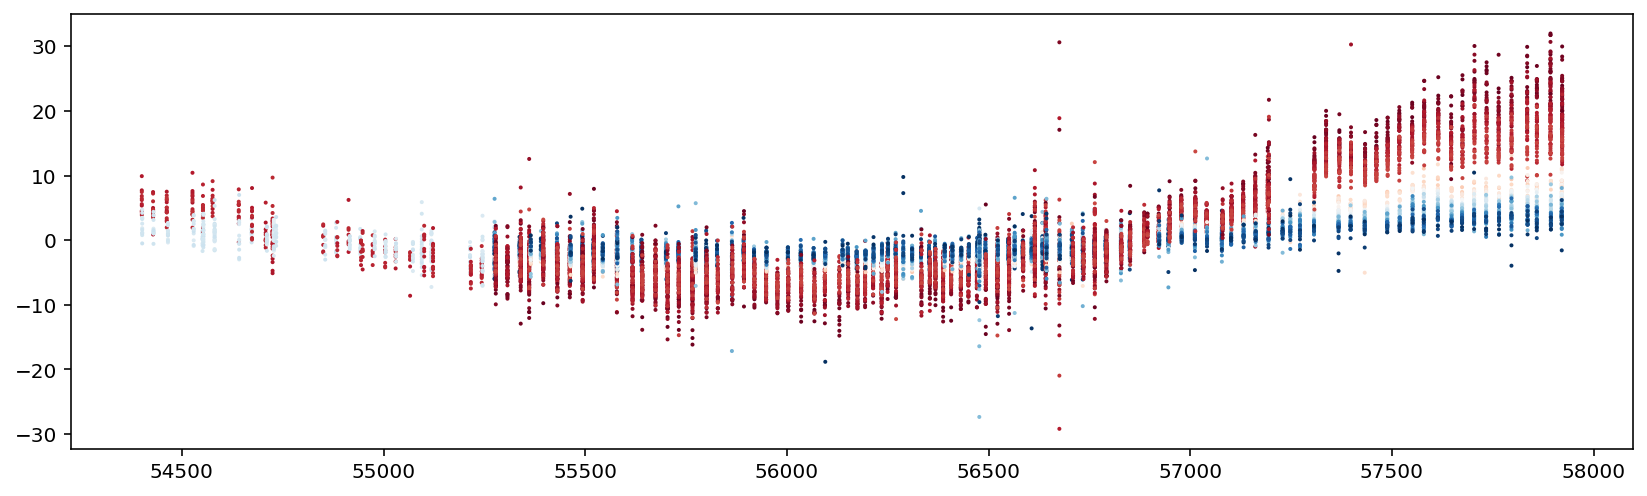

In [58]:
sec_to_day = 24*3600
plt.figure(figsize=[14,4])
plt.scatter(x=psr.toas/sec_to_day,
            y=(psr.residuals)*1e6,
            s=1,
            c=psr.freqs,cmap='RdBu')
# plt.xlim(57000,58000)
plt.show()

The GPs are natively returned as delays in seconds so we can subtract them from the residuals to see what residuals `Enterprise` is actually calculating during the analysis. The following function calculates the epoch averaged TOAs after subtracting the given `correction` GPs. 

In [66]:
resids,msks=epoch_ave_resid(psr, correction= mn_DM + mn_dmgp + mn_chrom_gp) #This is all the chromatic GPs, DM1/DM2 + DMGP + ChromGP

In [62]:
masks = list(msks.keys()) #This shows the two masks created for the different receivers. This allows us to plot by frequency.
masks

['Rcvr_800', 'Rcvr1_2']

In [67]:
all_chrgp = mn_DM + mn_dmgp + mn_chrom_gp

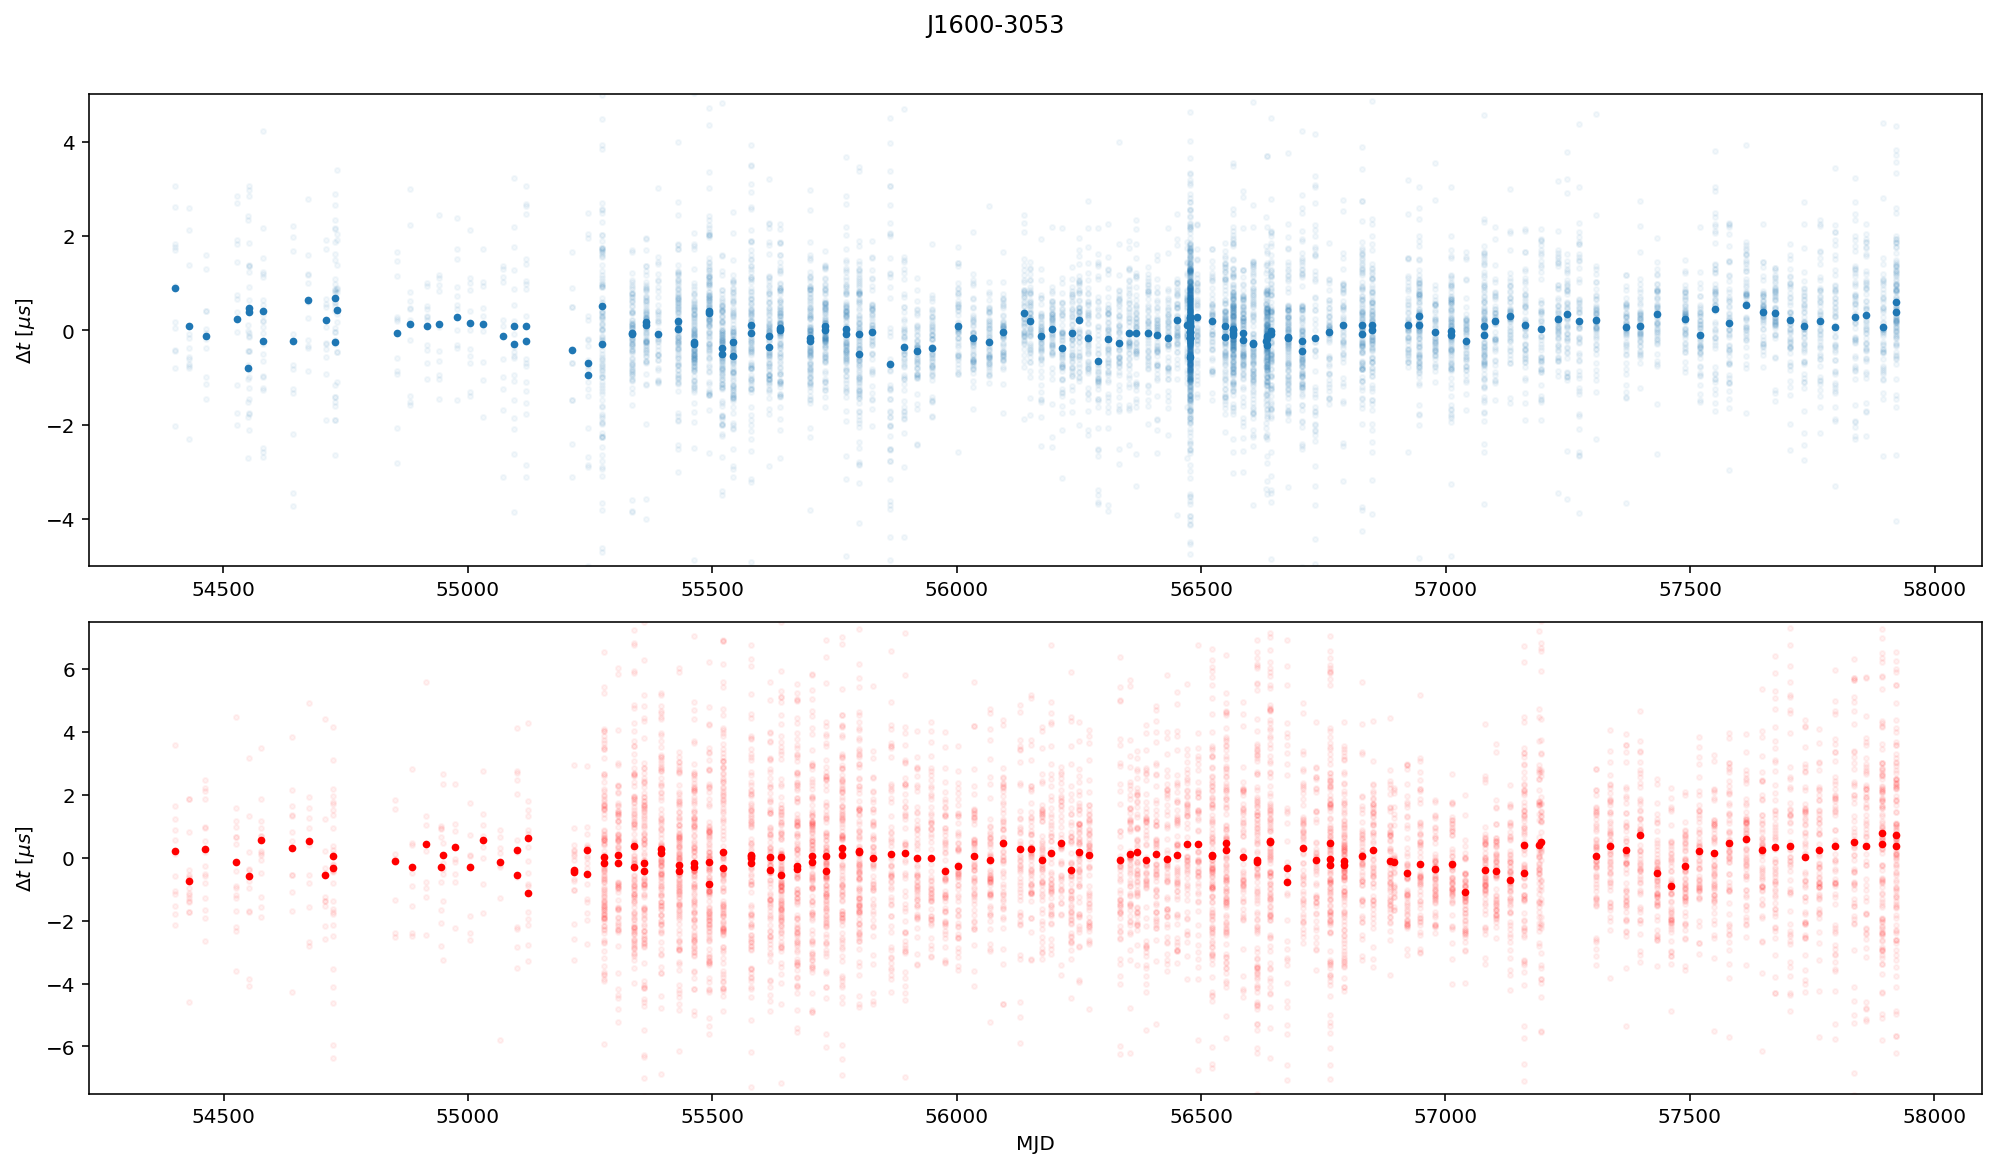

In [93]:
sec_to_day = 24*3600
fig=plt.figure(figsize=[14,8])
fig.add_subplot(211)
high_rec = 'Rcvr1_2'

plt.scatter(x=resids[high_rec][:,0]/sec_to_day,
            y=resids[high_rec][:,1]*1e6-np.mean(resids[high_rec][:,1]*1e6),
            s=8,c='C0')
plt.scatter(x=psr.toas[msks[high_rec]]/sec_to_day,
            y=((psr.residuals-all_chrgp)[msks[high_rec]]-(psr.residuals-all_chrgp)[msks[high_rec]].mean())*1e6,
            s=6,
            c='C0',alpha=0.05)
plt.ylim(-5,5)
# plt.xlim(56400,56600)
plt.ylabel(r'$\Delta t$ [$\mu s$]')
# plt.axvline(57600,linestyle='--',color='k')

fig.add_subplot(212)
low_rec = 'Rcvr_800'
plt.scatter(x=resids[low_rec][:,0]/sec_to_day,
            y=resids[low_rec][:,1]*1e6-np.mean(resids[low_rec][:,1]*1e6),
            s=8, c='red')
plt.scatter(x=psr.toas[msks[low_rec]]/sec_to_day,
            y=((psr.residuals-all_chrgp)[msks[low_rec]]-(psr.residuals-all_chrgp)[msks[low_rec]].mean())*1e6,
            s=6,
            c='red',alpha=0.05)#psr.freqs,cmap='RdBu')
# plt.xlim(57000,58000)
# plt.xlim(56400,56600)
# plt.axvline(57600,linestyle='--',color='k')
plt.ylim(-7.5,7.5)

plt.ylabel(r'$\Delta t$ [$\mu s$]')
plt.xlabel('MJD')
fig.suptitle(psrname,y=1.01)
fig.tight_layout()
plt.show()

The masks allow us to easily separate by receiver band, so we can for instance see how the DM is really a function of frequency. 

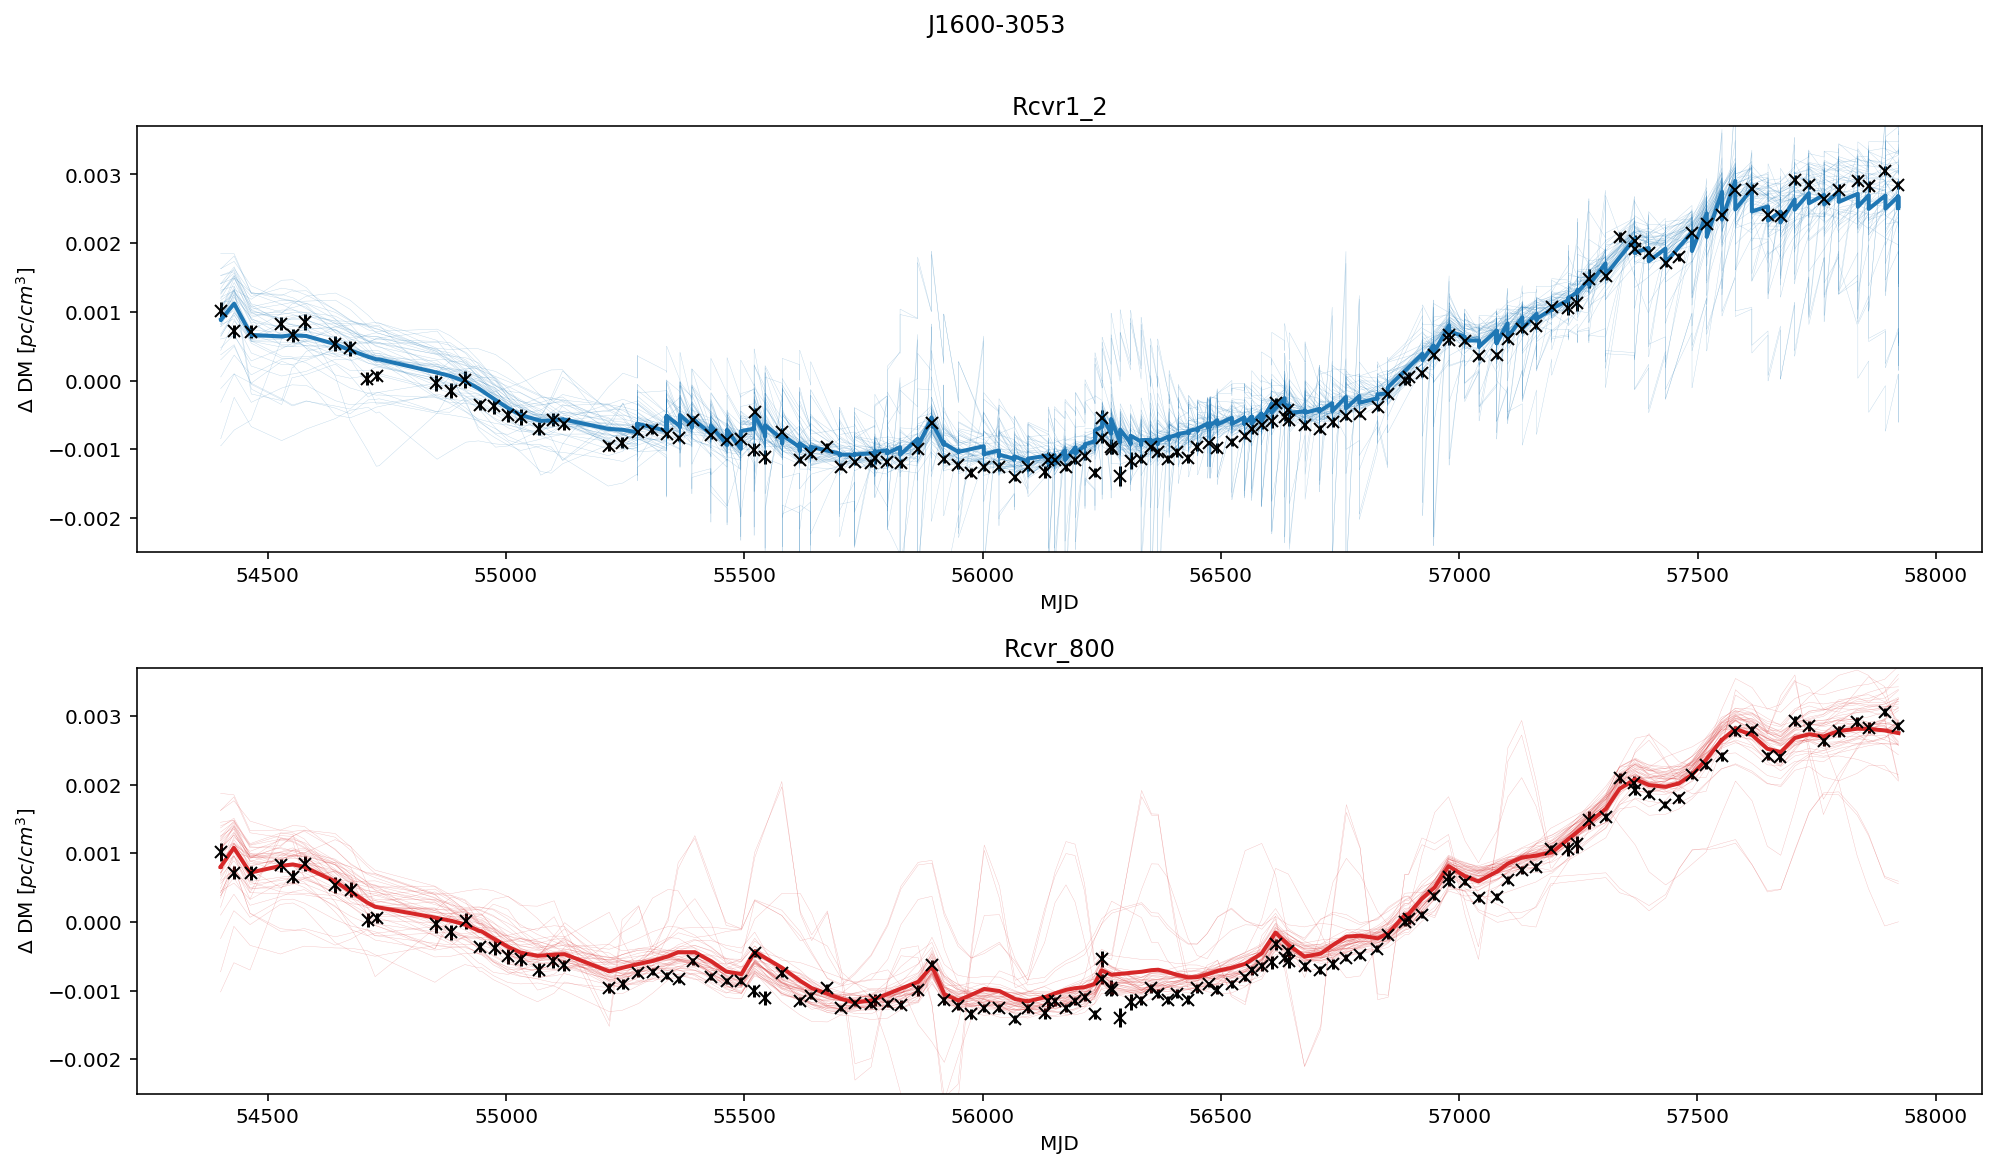

In [91]:
sec_to_day = 24*3600
fig=plt.figure(figsize=[14,8])
fig.add_subplot(211)
high_rec = 'Rcvr1_2'
for dm in dm_units:
    plt.plot(psr.toas[msks[high_rec]]/(24*3600),(dm-dm.mean())[msks[high_rec]],linewidth=0.2,alpha=0.3,color='C0')

plt.plot(psr.toas[msks[high_rec]]/(24*3600),(dm_mean-dm_mean.mean())[msks[high_rec]],linewidth=2,color='C0')
plt.errorbar(x=dmx['DMXEP'],
             y=dmx['DMX_value']-dmx['DMX_value'].mean(),
             yerr=dmx['DMX_var_err'],
             marker='x',color='k',linestyle='none')

plt.ylim(-0.0025,0.0037) # J1600
plt.xlabel('MJD')
plt.ylabel(r'$\Delta$ DM [$pc/cm^3$]')
plt.title(high_rec)

fig.add_subplot(212)
low_rec = 'Rcvr_800'
for dm in dm_units:
    plt.plot(psr.toas[msks[low_rec]]/(24*3600),(dm-dm.mean())[msks[low_rec]],linewidth=0.2,alpha=0.3,color='C3')

plt.plot(psr.toas[msks[low_rec]]/(24*3600),(dm_mean-dm_mean.mean())[msks[low_rec]],linewidth=2,color='C3')
plt.errorbar(x=dmx['DMXEP'],
             y=dmx['DMX_value']-dmx['DMX_value'].mean(),
             yerr=dmx['DMX_var_err'],
             marker='x',color='k',linestyle='none')

plt.ylim(-0.0025,0.0037)

plt.title(low_rec)
plt.ylabel(r'$\Delta$ DM [$pc/cm^3$]')
plt.xlabel('MJD')
fig.suptitle(psrname,y=1.01)
fig.tight_layout()
plt.show()

Here we just plot the residuals along with the scattering GP to see if there is interesting that is missed by the current modeling. 

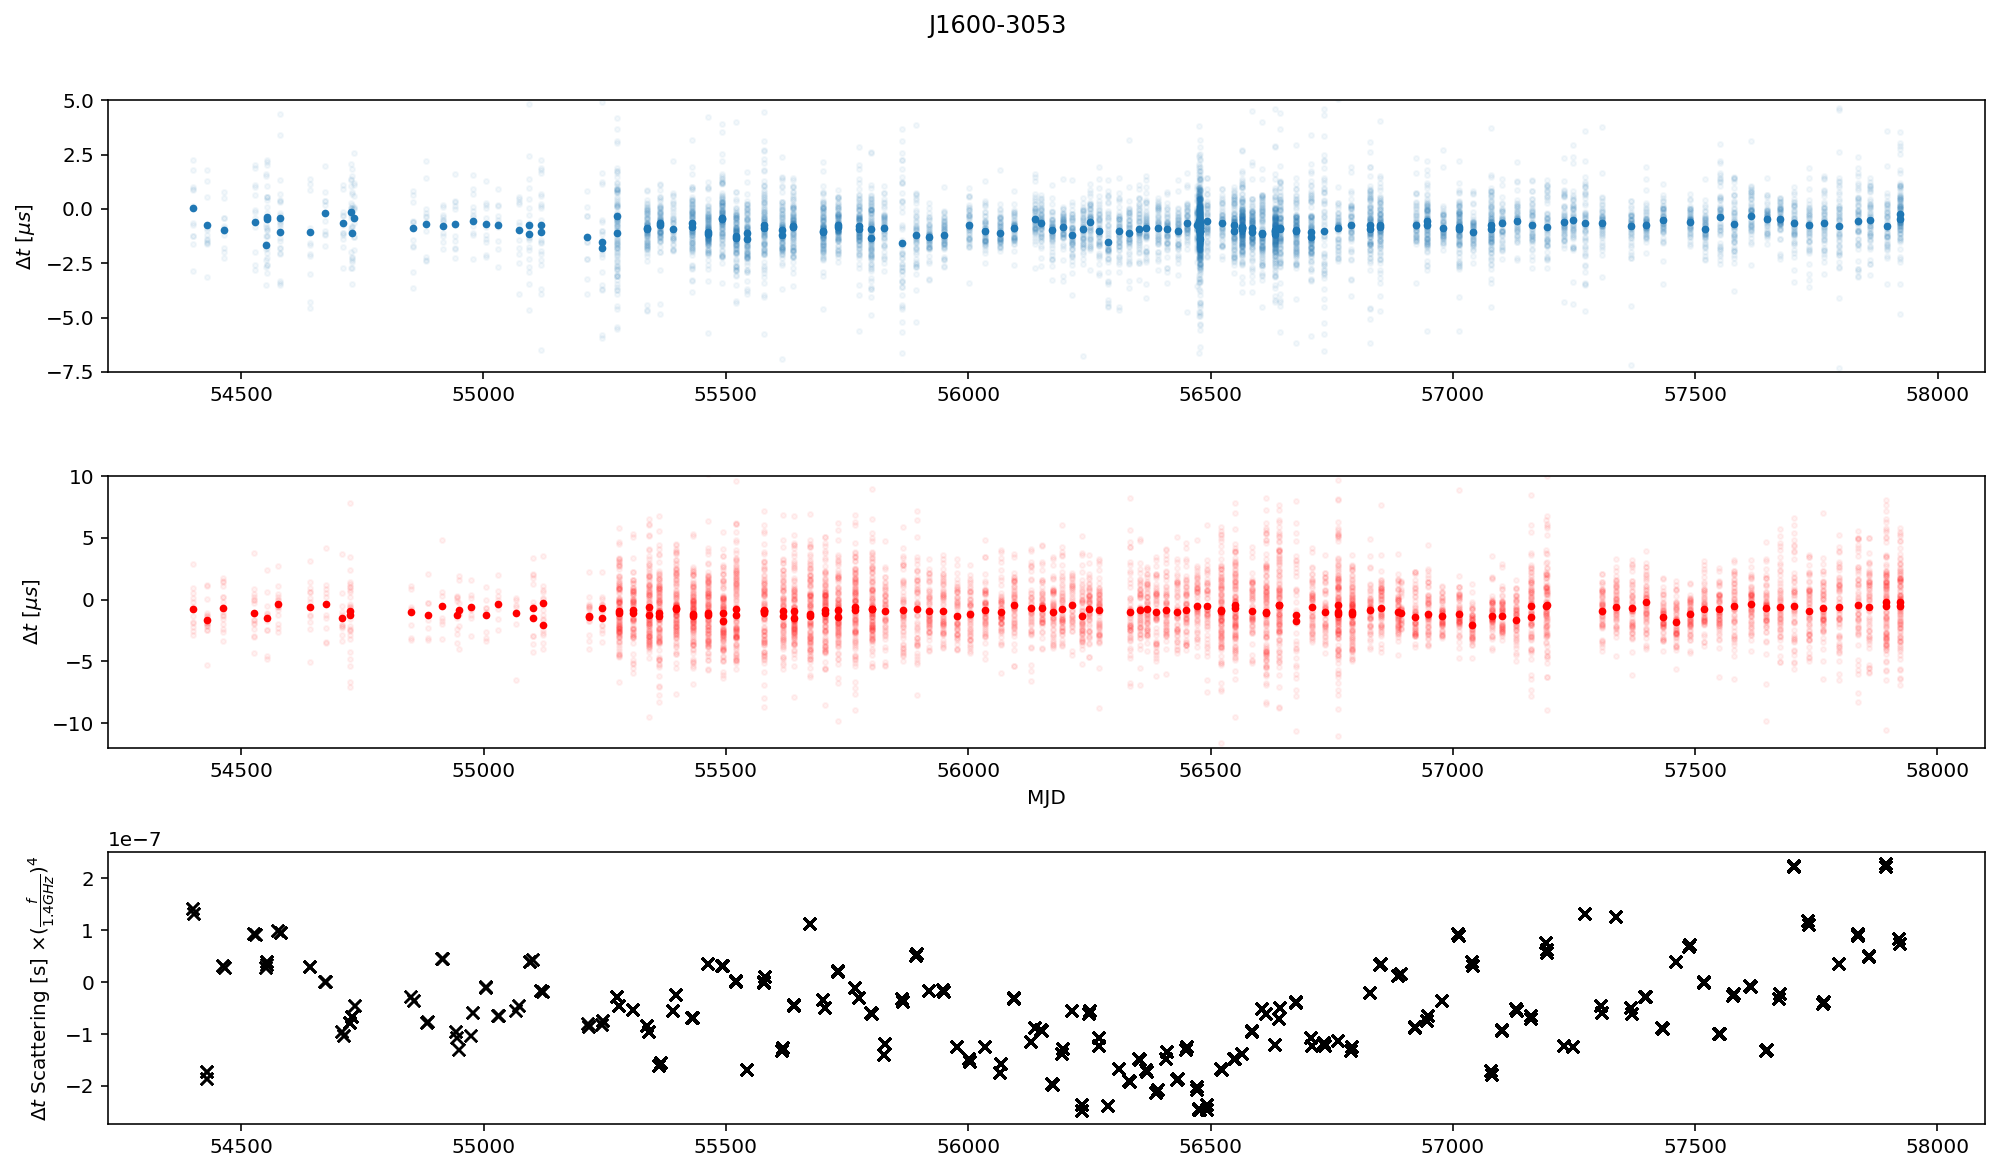

In [94]:
sec_to_day = 24*3600
fig=plt.figure(figsize=[14,8])
fig.add_subplot(311)
plt.scatter(x=resids['Rcvr1_2'][:,0]/sec_to_day,
            y=resids['Rcvr1_2'][:,1]*1e6,
            s=8,c='C0')
plt.scatter(x=psr.toas[psr.flags['fe']=='Rcvr1_2']/sec_to_day,
            y=(psr.residuals-all_chrgp)[psr.flags['fe']=='Rcvr1_2']*1e6,
            s=6,
            c='C0',alpha=0.05)
plt.ylim(-7.5,5)
plt.ylabel(r'$\Delta t$ [$\mu s$]')

fig.add_subplot(312)
plt.scatter(x=resids['Rcvr_800'][:,0]/sec_to_day,
            y=resids['Rcvr_800'][:,1]*1e6,
            s=8,c='red')
plt.scatter(x=psr.toas[psr.flags['fe']=='Rcvr_800']/sec_to_day,
            y=(psr.residuals-all_chrgp)[psr.flags['fe']=='Rcvr_800']*1e6,
            s=6,
            c='red',alpha=0.05)#psr.freqs,cmap='RdBu')
plt.ylim(-12,10)

plt.ylabel(r'$\Delta t$ [$\mu s$]')
plt.xlabel('MJD')

fig.add_subplot(313)
plt.plot(psr.toas/sec_to_day,mn_chrom_gp*(psr.freqs/1400)**4,'x',color='k')
plt.ylabel(r'$\Delta t$ Scattering [s] $\times (\frac{f}{1.4GHz})^4$')
fig.suptitle(psrname,y=1.01)
fig.tight_layout(pad=1.01)
plt.show()





In [78]:
everything = np.array([sr.reconstruct_signal(gp_type='all',det_signal=True, idx=idx)[psrname] for idx in idxs])

In [80]:
mn_all = np.mean(everything, axis=0)

In [81]:
resids2,msks=epoch_ave_resid(psr, correction= mn_all) #This is all te chromatic GPs, DM1/DM2 + DMGP + ChromGP

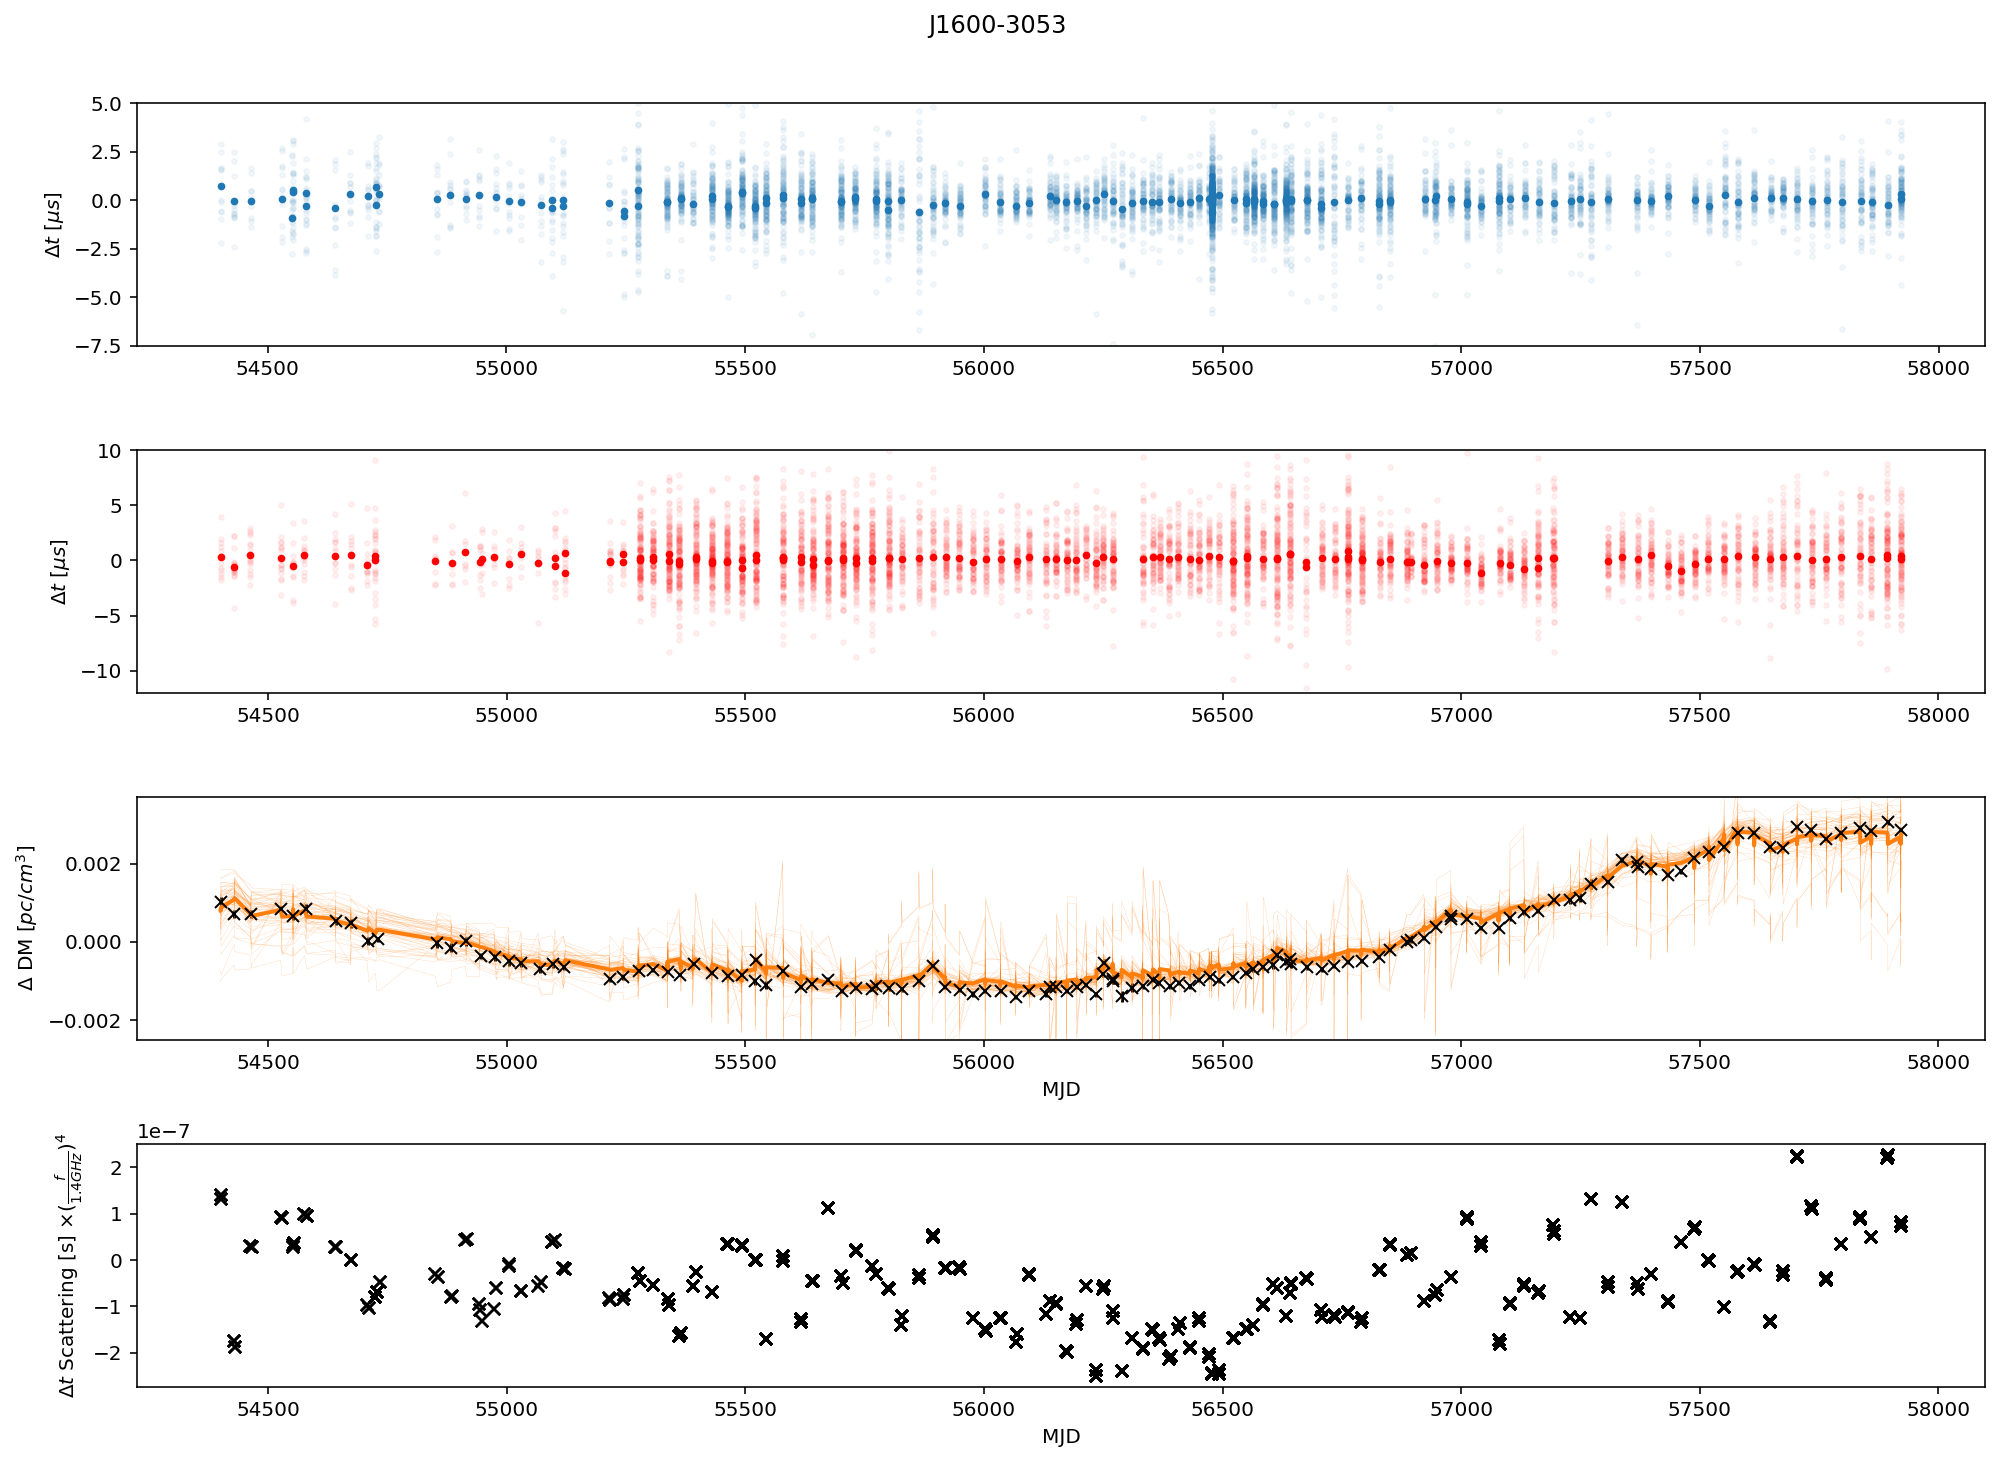

In [95]:
sec_to_day = 24*3600
fig=plt.figure(figsize=[14,10])
fig.add_subplot(411)
plt.scatter(x=resids2['Rcvr1_2'][:,0]/sec_to_day,
            y=resids2['Rcvr1_2'][:,1]*1e6,
            s=8,c='C0')
plt.scatter(x=psr.toas[psr.flags['fe']=='Rcvr1_2']/sec_to_day,
            y=(psr.residuals-mn_all)[psr.flags['fe']=='Rcvr1_2']*1e6,
            s=6,
            c='C0',alpha=0.05)
plt.ylim(-7.5,5)
plt.ylabel(r'$\Delta t$ [$\mu s$]')

fig.add_subplot(412)

plt.scatter(x=resids2['Rcvr_800'][:,0]/sec_to_day,
            y=resids2['Rcvr_800'][:,1]*1e6,
            s=8,c='red')
plt.scatter(x=psr.toas[psr.flags['fe']=='Rcvr_800']/sec_to_day,
            y=(psr.residuals-mn_all)[psr.flags['fe']=='Rcvr_800']*1e6,
            s=6,
            c='red',alpha=0.05)#psr.freqs,cmap='RdBu')
plt.ylim(-12,10)

plt.ylabel(r'$\Delta t$ [$\mu s$]')

fig.add_subplot(413)

for dm in dm_units:
    plt.plot(psr.toas/(24*3600),dm-dm.mean(),linewidth=0.2,alpha=0.3,color='C1')

plt.plot(psr.toas/(24*3600),dm_mean-dm_mean.mean(),linewidth=2,color='C1')
plt.errorbar(x=dmx['DMXEP'],
             y=dmx['DMX_value']-dmx['DMX_value'].mean(),
             yerr=dmx['DMX_var_err'],
             marker='x',color='k',linestyle='none')

plt.ylim(-0.0025,0.0037) # J1600
#plt.ylim(-0.0015,0.0023) # J1911
plt.xlabel('MJD')
plt.ylabel(r'$\Delta$ DM [$pc/cm^3$]')

fig.add_subplot(414)
plt.plot(psr.toas/sec_to_day,mn_chrom_gp*(psr.freqs/1400)**4,'x',color='k')
plt.ylabel(r'$\Delta t$ Scattering [s] $\times (\frac{f}{1.4GHz})^4$')
plt.xlabel('MJD')

fig.suptitle(psrname,y=1.01)
fig.tight_layout(pad=1.01)
plt.show()



